# 使用Autograd来自动求导

- 给需要求梯度的变量增加梯度存储空间
- 在record()内对变量进行运算
- 增加头梯度
- Python中的`with`是怎么回事

In [1]:
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.autograd as ag

## 简单的自动梯度计算

计算$f(x)$对x的梯度

$$f(x)= \text{sigmoid}(x) = \frac{1}{1+e^{-x}}$$

其中x是一个NDArray的tensor

In [2]:
def f(x):
    return 1 / (1 + nd.exp(-x))

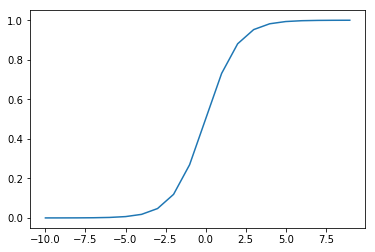

In [3]:
import matplotlib.pyplot as plt
x = nd.arange(-10,10,1)
y = f(x)
plt.plot(x.asnumpy(), y.asnumpy())
plt.show()

In [4]:
x = nd.arange(-5,5)
x.attach_grad()
with ag.record():
    y = f(x)
y.backward()
x.grad


[ 0.00664806  0.01766271  0.04517666  0.10499358  0.19661194  0.25
  0.19661197  0.10499357  0.04517666  0.01766271]
<NDArray 10 @cpu(0)>

## 头梯度的计算

$$\frac{dz}{dx} = \frac{dz}{dy}\cdot\frac{dy}{dx}$$


In [5]:
x = nd.arange(-5,5)
x.attach_grad()
with ag.record():
    y = f(x)
y_gradinet = nd.random_normal(0, 1, shape=y.shape)
y.backward(y_gradinet)
x.grad


[ 0.00199646  0.00408136  0.04740518 -0.03405355 -0.00192459  0.18421559
  0.33821863  0.04898624 -0.04848981  0.01550959]
<NDArray 10 @cpu(0)>

## BatchNorm的梯度计算

In [6]:
import mxnet as md
import mxnet.ndarray as nd
def spatial_batchnorm(x, gamma, beta):
    """
    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter of shape (C,)
    - beta: Shift parameter of shape (C,)
    
    Returns
    -out: output data, of shape(N, C, H, W)
    """
    x_trans = x.transpose(axes=(0,2,3,1)).reshape((-1, x.shape[1]))
    mean = nd.mean(x_trans, axis=0)
    var = nd.mean((x_trans - mean)**2, axis=0)
    out = (x_trans - mean) / nd.sqrt(var) * gamma + beta
    out = out.reshape((x.shape[0], x.shape[2], x.shape[3], x.shape[1]))                                   
    return nd.transpose(out, axes=(0,3,1,2))

In [7]:
x = nd.random_normal(0, 1, shape=(1, 64, 224, 224))
gamma = nd.random_normal(0, 1, shape=(64,))
beta = nd.random_normal(0, 1, shape=(64,))
x.attach_grad()

In [8]:
with ag.record():
    y = spatial_batchnorm(x, gamma, beta)
y.backward()
x.grad # 结果好像是不对的，MXNET能对transpose自动求导吗？


[[[[  6.78542449e-08   5.46346506e-08   6.52816183e-08 ...,
      5.58515794e-08   6.05863306e-08   5.31665769e-08]
   [  5.98560348e-08   6.46377174e-08   6.08461619e-08 ...,
      7.36265235e-08   6.06228028e-08   5.31733306e-08]
   [  5.59937874e-08   5.38107159e-08   6.05352000e-08 ...,
      6.05112831e-08   5.15072394e-08   4.98415496e-08]
   ..., 
   [  6.25783230e-08   5.35891154e-08   5.89680980e-08 ...,
      6.04450818e-08   6.57511166e-08   5.53022268e-08]
   [  5.55349544e-08   5.21602885e-08   5.37953575e-08 ...,
      7.05650365e-08   4.47012987e-08   5.60945104e-08]
   [  6.32689563e-08   6.27494359e-08   5.42643690e-08 ...,
      5.68156047e-08   5.67967575e-08   5.96532956e-08]]

  [[  8.44944292e-09   9.07673670e-09   1.39759466e-08 ...,
      1.00359934e-08  -5.59806923e-10  -8.53592752e-09]
   [  1.25006956e-08   1.48616062e-08   8.41612025e-09 ...,
      6.65064270e-09   1.97799928e-08   1.64961056e-09]
   [ -9.89707649e-10   1.68476184e-08  -4.06387007e-10 ...,


In [9]:
def trans(x):
    return x.transpose(axes=(0,2,1))

In [10]:
x = nd.ones((1,2,3))
x.attach_grad()

In [11]:
with ag.record():
    y = trans(x)
y_grad = nd.arange(0, y.size).reshape(y.shape)
y_grad


[[[ 0.  1.]
  [ 2.  3.]
  [ 4.  5.]]]
<NDArray 1x3x2 @cpu(0)>

In [12]:
y.backward(y_grad)
x.grad


[[[ 0.  2.  4.]
  [ 1.  3.  5.]]]
<NDArray 1x2x3 @cpu(0)>

# With语法的魔法是什么 

深入的学习可以参考：[浅谈 Python 的 with 语句](http://python.jobbole.com/82494/)

with后的那个对象是一个上下文管理器，定义了`__enter__`和`__exit__`两个方法，分别在进入with和离开with时调用，用于申请一些资源，以及处理一些资源释放问题。

实际上相当于构成了一个局部的作用域。

In [13]:
class DummyResource:
    def __init__(self, tag):
        self.tag = tag
        print ('Resource {}'.format(tag))
        
    def __enter__(self):
        print ('[Enter {}]: Allocate resource.'.format(self.tag))
        return self
    
    def __exit__(self, exc_type, exc_value, exc_tb):
        print ('[Exit {}]: Free resource.'.format(self.tag))
        if exc_tb is None:
            print ('[Exit {}]: Exited without exception.'.format(self.tag))
        else:
            print ('[Exit {}]: Exited with exception raised.'.format(self.tag))
            return False   # 可以省略，缺省的None也是被看做是False

In [14]:
with DummyResource('MYCONTEXT'):
    print('hello, world\n')

Resource MYCONTEXT
[Enter MYCONTEXT]: Allocate resource.
hello, world

[Exit MYCONTEXT]: Free resource.
[Exit MYCONTEXT]: Exited without exception.


In [15]:
with DummyResource('MYCONTEXT'):
    print('hello, world\n')
    raise Exception

Resource MYCONTEXT
[Enter MYCONTEXT]: Allocate resource.
hello, world

[Exit MYCONTEXT]: Free resource.
[Exit MYCONTEXT]: Exited with exception raised.


Exception: 